# Tooth and Cavity Instance Segmentation
Deep learning in dentistry holds a multitude of applications for identifying various dental conditions and diseases. Here, we train a deep-learning model for identifying and segmenting instances of the following:
- Caries
- Cavities
- Teeth
- Cracks

**Instance Segmentation** requires a model to not only create an image mask to classify objects pixel-by-pixel, but also to create boundaries to separate multiple instances of the same object. While multiple architectures are available for performing instance segmentation, we focus on training and comparing the following models:
- Mask RCNN
- YOLOv8

## Setup
Let's begin by importing necessary modules, set up some commonly used paths, and ingest our data. This data comes courtesy of Arab Academy on Roboflow:
- https://universe.roboflow.com/arab-academy-vf9su/dental-7yegp

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
torchvision.disable_beta_transforms_warning()

from torchvision import models, datasets
from torchvision.datasets import (
    CocoDetection,
    wrap_dataset_for_transforms_v2
)
from torchvision.transforms import v2

from types import SimpleNamespace
from pathlib import Path
from pprint import pprint
from typing import Optional
from collections import defaultdict
from tqdm.auto import tqdm

2024-08-06 22:37:57.107261: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 22:37:58.905987: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext tensorboard

In [3]:
FPATHS = SimpleNamespace()
FPATHS.data = Path("../data/")

FPATHS.data_train = FPATHS.data / "train"
FPATHS.data_valid = FPATHS.data / "valid"
FPATHS.data_test = FPATHS.data / "test"

FPATHS.data_annotations_fname = "_annotations.coco.json"
FPATHS.data_train_annotations = FPATHS.data_train / FPATHS.data_annotations_fname
FPATHS.data_valid_annotations = FPATHS.data_valid / FPATHS.data_annotations_fname
FPATHS.data_test_annotations = FPATHS.data_test / FPATHS.data_annotations_fname


### Defining Augmentations and Train/Val/Test Datasets
Since data provides bounding boxes, masks, and segmentations in the [COCO format](https://cocodataset.org/#home), we can utilize `torchvision.datasets.CocoDetection` class to help load the data in as a PyTorch Dataset.

We also define the augmentations to integrate with our training observations.

In [4]:
transforms = v2.Compose([
    v2.ToImageTensor(),
    v2.RandomPhotometricDistort(p=0.5),
    v2.SanitizeBoundingBox(),
    v2.ConvertImageDtype()
])

datasets = SimpleNamespace()
datasets.train = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_train,
    FPATHS.data_train_annotations,
    transforms=transforms
))

datasets.train_raw = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_train,
    FPATHS.data_train_annotations,
))

datasets.valid = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_valid,
    FPATHS.data_valid_annotations
)),

datasets.test = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_test,
    FPATHS.data_test_annotations
))

category_id_to_name = {
    0: "Null",
    1: "Caries",
    2: "Cavity",
    3: "Crack",
    4: "Tooth"
}

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Visualizing Instances
Let's build out some functionality to visualize the bounding boxes, masks, and segmentations of each observation. We define `plot_coco_image()` for this purpose.

In [5]:
def plot_coco_image(
        dataset: Dataset,
        index: int = 0,
        plot_masks: bool = True,
        plot_bboxes: bool = True,
        plot_segmentations: bool = True,
        plot_category_id: bool = True,
        category_names: Optional[dict[int, str]] = None
    ):
    image, target = dataset[index]
    bboxes = target["bbox"]
    masks = target["masks"]
    segmentations = target["segmentation"]
    categories = target["category_id"]

    fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

    if plot_masks:
        for i, mask in enumerate(masks):
            ax.imshow(mask + 0.5 * i, alpha=mask * 0.25, cmap="tab10", vmin=0, vmax=len(masks) / 2)

    if plot_bboxes:
        for bbox in bboxes:
            x, y, width, height = bbox
            patch = matplotlib.patches.Rectangle(
                (x, y),
                width,
                height,
                alpha=1,
                fill=False,
                edgecolor="red",
                linewidth=1,
                mouseover=True
            )
            ax.add_patch(patch)

    if plot_segmentations:
        for segmentation in segmentations:
            x = [val for i, val in enumerate(segmentation[0]) if i % 2 == 0]
            y = [val for i, val in enumerate(segmentation[0]) if i % 2 != 0]
            ax.plot(x, y, color="black")

    if plot_category_id:
        for i, bbox in enumerate(bboxes):
            x, y, width, height = bbox
            category_id = categories[i]

            if category_names is not None:
                display_text = category_names[category_id]
            else:
                display_text = category_id
            
            ax.text(x+6, y-8, display_text, color="white", fontsize=6, backgroundcolor=(1, 0 ,0, 0.25))
        
        
    return fig
    

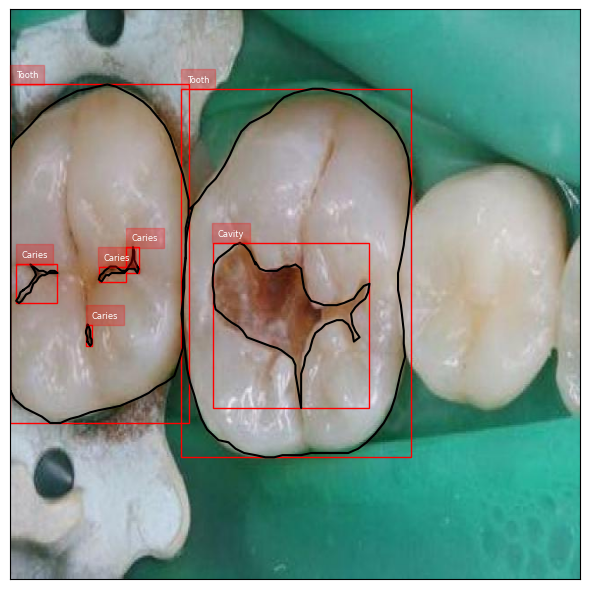

In [6]:
coco_image_example = plot_coco_image(
    datasets.test,
    5,
    plot_masks=False,
    plot_bboxes=True,
    plot_segmentations=True,
    plot_category_id=True,
    category_names=category_id_to_name,
)

In [7]:
coco_image_example.savefig("segmentation_example.png")


### Creating a PyTorch `DataLoader`
Dataloader's help us retrieve a batch of training samples for more seamless model training training. Since PyTorch expects each batch to be constant, we have to update our `collate_fn`. We define `custom_collate_function()` to represent each batch as a tuple `(images, targets)`. To ensure we can run the network on our GPU, we also have to move the images and certain targets to the GPU.

Here, we can the structure of each batch:

```python
# Start iterating through the dataloader
images, targets = next(iter(dataloader))

# Extracts the first instance in the batch
image = images[0]
target = targets[0]

# Access the data in the target
target_bboxes = target["bbox"]
target_areas = target["area"]
target_segmentation = target["segmentation"]
```

In [8]:
# Memory constraints limits us to only 2 observations/batch (8GB VRAM)
batch_size = 2

def custom_collate_function(batch, to_cuda: bool = True):
    images, targets = tuple(zip(*batch))

    if not to_cuda:
        return (images, targets)

    images = torch.stack(images).cuda()
    for target in targets:
        pass
        target["boxes"] = target["boxes"].cuda()
        target["bbox"] = torch.Tensor(target["bbox"]).cuda()
        target["labels"] = torch.Tensor(target["labels"]).cuda()
        
    return (images, targets)

dataloaders = SimpleNamespace()
dataloaders.train = DataLoader(
    datasets.train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_function
)

dataloaders.valid = DataLoader(
    datasets.valid,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_function
)

dataloaders.test = DataLoader(
    datasets.test,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_function
)

## Model Training

For instance segmentation, PyTorch provides [Mask R-CNN](https://pytorch.org/vision/0.9/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).


In [9]:
MAX_EPOCHS = 2

# How many batches to run through before logging our metrics
LOG_BATCH_INTERVAL = 16

### Mask-RCNN

In [10]:
mask_rcnn = models.get_model(
    "maskrcnn_resnet50_fpn_v2",
    weights=None,
    weights_backbone=None
)

mask_rcnn.cuda()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [11]:
mask_rcnn_optimizer = torch.optim.Adam(mask_rcnn.parameters(), lr=1e-3)

In [12]:
# Accompany writer with `tensorboard --logdir=logs/mask_rcnn`
writer = SummaryWriter("logs/mask_rcnn")


best_valid_loss = np.inf
for epoch in range(MAX_EPOCHS):
    # Log our losses at the LOG_BATCH_INTERVAL
    train_epoch_loss = 0.0
    train_epoch_samples = 0
    valid_epoch_loss = 0.0
    valid_epoch_samples = 0
    
    # ----- TRAIN LOOP ----- #
    mask_rcnn.train()
    train_pbar = tqdm(
        enumerate(dataloaders.train),
        total=len(dataloaders.train),
        desc=f"(Train) Epoch: {epoch}/{MAX_EPOCHS-1}"
    )
    for i, (images, targets) in train_pbar:
        loss_dict = mask_rcnn(images, targets)
        loss_dict["loss_overall"] = sum(loss for loss in loss_dict.values())
    
        mask_rcnn_optimizer.zero_grad()
        loss_dict["loss_overall"].backward()
        mask_rcnn_optimizer.step()

        # Update our progress bar, keeping track of our running loss & samples
        train_epoch_loss += loss_dict["loss_overall"].item()
        train_epoch_samples += len(images)
        train_epoch_loss_avg = train_epoch_loss / train_epoch_samples
        train_pbar.set_postfix({"Avg Loss": f"{train_epoch_loss_avg:.4f}"})

        # Log our metrics
        if (i + 1) % LOG_BATCH_INTERVAL == 0:
            global_step = i + epoch * len(dataloaders.train)
            writer.add_scalar("Loss/train_running", train_epoch_loss_avg, global_step)

    # Log train loss from epoch
    writer.add_scalar("Loss/train_epoch", train_epoch_loss_avg, epoch)

    
    # ----- VALIDATION LOOP ----- #
    mask_rcnn.eval()
    with torch.no_grad():
        valid_pbar = tqdm(
            enumerate(dataloaders.valid),
            total=len(dataloaders.valid),
            desc=f"(Valid) Epoch: {epoch}/{MAX_EPOCHS-1}"
        )
        for i, (images, targets) in valid_pbar:
            loss_dict = mask_rcnn(images, targets)
            loss_dict["loss_overall"] = sum(loss for loss in loss_dict.values())

            # Update our progress bar, keeping track of our running loss & samples
            valid_epoch_loss += loss_dict["loss_overall"].item()
            valid_epoch_samples += len(images)
            valid_epoch_loss_avg = valid_epoch_loss / valid_epoch_samples
            valid_pbar.set_postfix({"Avg Loss": f"{valid_epoch_loss_avg:.4f}"})

            # Log our metrics
            if (i + 1) % LOG_BATCH_INTERVAL == 0:
                global_step = i + epoch * len(dataloaders.valid)
                writer.add_scalar("Loss/valid_running", valid_epoch_loss_avg, global_step)

    # Log valid loss from epoch
    writer.add_scalar("Loss/valid_epoch", valid_epoch_loss_avg, epoch)

    # Epoch Summary
    print(f"EPOCH {epoch}/{MAX_EPOCHS-1}")
    print(f"  Train Loss: {train_epoch_loss_avg:.4f}")
    print(f"  Valid Loss: {valid_epoch_loss_avg:.4f}")
    print("-" * 10)
    
    # Model Checkpointing
    if valid_epoch_loss_avg < best_valid_loss:
        torch.save(mask_rcnn.state_dict(), f"model_checkpoint_{epoch}.pth")
        
    

writer.close()

(Train) Epoch: 0/1:   0%|          | 0/2957 [00:00<?, ?it/s]

KeyboardInterrupt: 